In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_csv('C:/Users/Ax/Desktop/chars/train.csv', encoding='utf-8')
df_train['id'] = df_train['id'].apply(str)

In [3]:
df_test = pd.read_csv('C:/Users/Ax/Desktop/chars/test.csv', encoding='utf-8')
df_test['test_id'] = df_test['test_id'].apply(str)

In [4]:
df_all = pd.concat((df_train, df_test),sort=True)
df_all['question1'].fillna('', inplace=True)
df_all['question2'].fillna('', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [6]:
counts_vectorizer = CountVectorizer(max_features=10000-1).fit(
    itertools.chain(df_all['question1'], df_all['question2']))
other_index = len(counts_vectorizer.vocabulary_)

In [7]:
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

In [9]:
def create_padded_seqs(texts, max_len=20):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)

In [10]:
#df_all = df_all.sample(1000) # Just for debugging

In [11]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(create_padded_seqs(df_all[df_all['id'].notnull()]['question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.1, random_state=1989)

In [12]:
import keras.layers as lyr
from keras.models import Model

In [30]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 300)
seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(32, activation='sigmoid')(merge_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 20, 300)      808500      input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256)          570368      embedding_2[0][0]                
          

In [32]:
model.fit([X1_train, X2_train], y_train, 
          validation_data=([X1_val, X2_val], y_val), 
          batch_size=64, epochs=10, verbose=2)

Train on 203508 samples, validate on 50878 samples
Epoch 1/10
 - 147s - loss: 0.4144 - val_loss: 0.3335
Epoch 2/10
 - 147s - loss: 0.2854 - val_loss: 0.2661
Epoch 3/10
 - 147s - loss: 0.2221 - val_loss: 0.2429
Epoch 4/10
 - 153s - loss: 0.1798 - val_loss: 0.2309
Epoch 5/10
 - 149s - loss: 0.1464 - val_loss: 0.2351
Epoch 6/10
 - 147s - loss: 0.1166 - val_loss: 0.2499
Epoch 7/10
 - 149s - loss: 0.0921 - val_loss: 0.2683
Epoch 8/10
 - 148s - loss: 0.0731 - val_loss: 0.2986
Epoch 9/10
 - 149s - loss: 0.0595 - val_loss: 0.3186
Epoch 10/10
 - 149s - loss: 0.0496 - val_loss: 0.3503


In [33]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')

In [34]:
F_train = features_model.predict([X1_train, X2_train], batch_size=64)
F_val = features_model.predict([X1_val, X2_val], batch_size=64)

In [35]:
import xgboost as xgb

In [36]:
dTrain = xgb.DMatrix(F_train, label=y_train)
dVal = xgb.DMatrix(F_val, label=y_val)

In [45]:
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 9,
    'subsample': 0.9,
    'colsample_bytree': 1 / F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}
bst = xgb.train(xgb_params, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')], 
                verbose_eval=10, early_stopping_rounds=10)

[0]	train-logloss:0.660504	val-logloss:0.662923
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[10]	train-logloss:0.43992	val-logloss:0.467727
[20]	train-logloss:0.327839	val-logloss:0.37369
[30]	train-logloss:0.264958	val-logloss:0.324712
[40]	train-logloss:0.220948	val-logloss:0.293513
[50]	train-logloss:0.187915	val-logloss:0.271873
[60]	train-logloss:0.162466	val-logloss:0.256672
[70]	train-logloss:0.144503	val-logloss:0.247411
[80]	train-logloss:0.129654	val-logloss:0.240586
[90]	train-logloss:0.117203	val-logloss:0.23526
[100]	train-logloss:0.106697	val-logloss:0.231831
[110]	train-logloss:0.097804	val-logloss:0.229468
[120]	train-logloss:0.090606	val-logloss:0.228007
[130]	train-logloss:0.083734	val-logloss:0.226698
[140]	train-logloss:0.077725	val-logloss:0.226177
[150]	train-logloss:0.072251	val-logloss:0.225875
[160]	train-logloss:0.067387	val-logloss:0.225909
Stopping. Best it

In [46]:
X1_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question1'])
X2_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question2'])

In [47]:
F_test = features_model.predict([X1_test, X2_test], batch_size=64)

In [48]:
dTest = xgb.DMatrix(F_test)

In [49]:
df_sub = pd.DataFrame({
        'test_id': df_all[df_all['test_id'].notnull()]['test_id'].values,
        'y_pre': bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
    }).set_index('test_id')

In [50]:
df_sub.head()

,y_pre
test_id,
0,0.054278
1,0.978075
2,0.240083
3,0.998168
4,0.539208


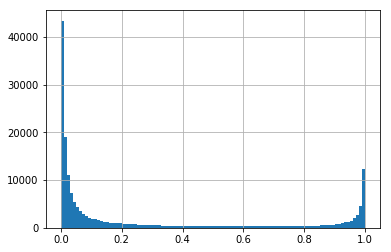

In [51]:
df_sub['y_pre'].hist(bins=100)

In [52]:
df_sub.to_csv('submission20180624LSTM_06.csv', index=False)